<a href="https://colab.research.google.com/github/EricQiu6/multiclass-classification-from-ground-up/blob/main/multiclass_classification_from_ground_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=16073s&ab_channel=DanielBourke

* torchvision - the base library
* torchvision.datasets - get datasets and data loading functions
* torchvision.models - get pretrained vision models, useful for transfer learning
* torchvision.transforms - turn vision data into numbers
* torch.utils.data.Dataset - to create a dataset
* torch.utils.data.DataLoader - Creates a Python iterable over a dataset



In [45]:
# importing the libraries above
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
# convert image to tensor
from torchvision.transforms import ToTensor

# for visualization
import matplotlib.pyplot as plt

#check versions
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


## 1. Getting a dataset

torchvision provides many built-in datasets, we'll use FashionMNIST

In [46]:
# Setup training data - in my research this has to be replaced
# by fetching lab data from server
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data",
    train = True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [47]:
len(train_data), len(test_data)

(60000, 10000)

In [48]:
# see the first training example, notice that ToTensor has transformed
# the images to tensor
image, label = train_data[0]

In [49]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [50]:
# note that color channel is 1 here because the dataset is black and set
print(f"Image shape: {image.shape} -> [color_channels, height, width]")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]


In [51]:
# the goal is to classify images based on the categories above

## 1.2 Visualizing data

Text(0.5, 1.0, '9')

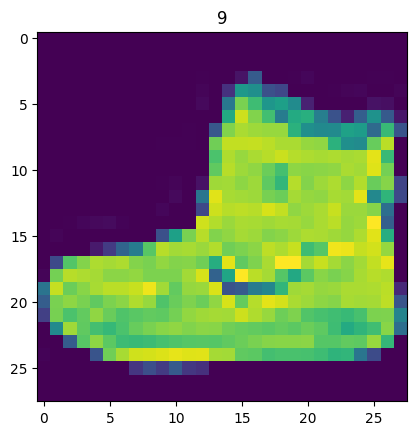

In [52]:
#squeee removes axes of length one
plt.imshow(image.squeeze())
plt.title(label)

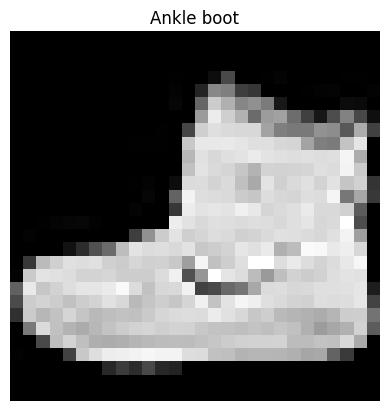

In [53]:
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False);

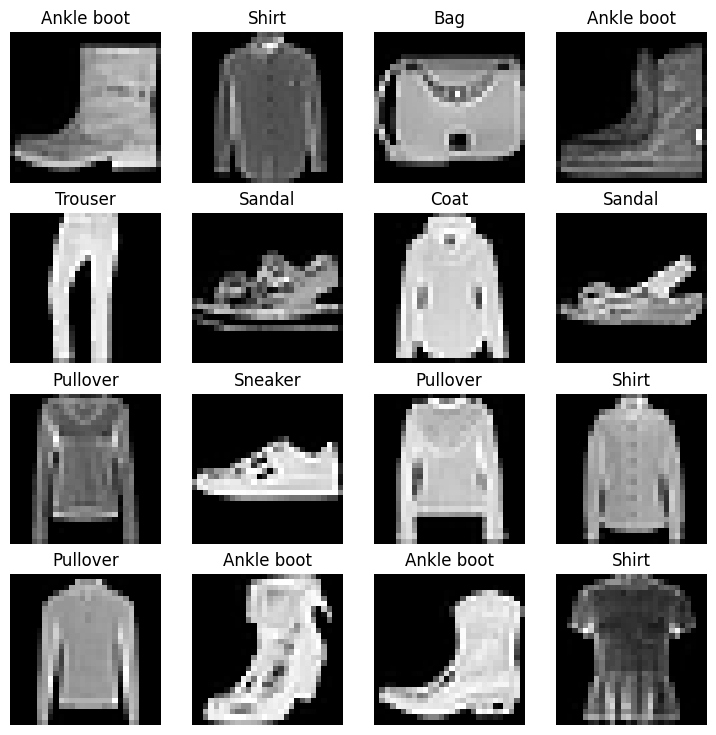

In [54]:
# Plot more random images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  # gets a random index from the available ones in the image dataset
  random_idx = torch.randint(0, len(train_data), size=[1]).item()

  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)


In [55]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

as we can see above, right now our data is in the form of PyTorch Datasets.

Recall DataLoader turns dataset into a Python iterable
we want to group data into batches because
1. memory cannot look at 60000 images in one bit
2. gives neural network more chances to update its gradients per epoche

In [56]:
from torch.utils.data import DataLoader
# chooses a batch size of 32
BATCH_SIZE = 32
# shuffled because data was ordered in categories, which is something the model
# should not learn
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE, shuffle=True)

# not shuffled because inconvient to shuffle every time in testing, apparently
test_dataloader = DataLoader(dataset=test_data, batch_size = BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b5f229e6410>,
 <torch.utils.data.dataloader.DataLoader at 0x7b5f22613370>)

In [57]:
# let's checkout the specs of the dataloaders
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b5f229e6410>, <torch.utils.data.dataloader.DataLoader object at 0x7b5f22613370>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [58]:
# Check out what's inside the training dataloader

# recall dataloader is an iterable -- can be put into iter()
# next() returns the next item of an iterable
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


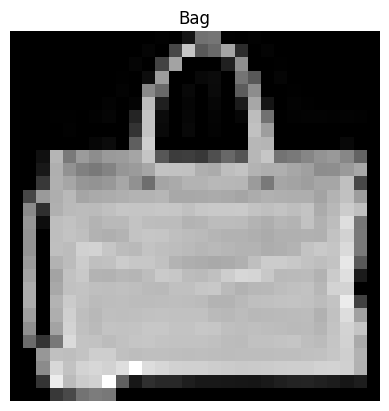

In [59]:
# show a random sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

3. Model 0: Build a basline model
When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [60]:
# We are flattening the output because we are using a linear model as baseline,
# which takes a linear vector that can be created by flatten
# This is a demo of what flatten does

# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [61]:
# the baseline model

from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        # note here that the out feature of previous layer should be the same as the in feature of the next layer
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [62]:
torch.manual_seed(42)

# Setup model with random input parameters
model_0 = FashionMNISTModelV0(
    input_shape=28*28, # this is 28*28
    hidden_units=10, # how many units in the hidden layer, arbitrary choice I think
    output_shape=len(class_names) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [63]:
# do forward pass on a random "image"
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [64]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

## 3.1 Setup loss, optimizer and evaluation metrics
* Loss function - since we're working with multi-class data, our loss function will be nn.CrossEntropyLoss()
* Optimizer - our optimizer torch.optim.SGD() (stochastic gradient descent)
* Evaluation metric - since we're working on a classification problem, let's use accruacy as our evaluation metric

In [65]:
import requests
from pathlib import Path

# for my research, check if he has a evaluation metric for my problem, or ask Rachit, or use torch metrics

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


helper_functions.py already exists, skipping download...


In [66]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## 3.2 Creating a function to time our experiments
Machine learning is very experimental.

Two of the main things you'll often want to track are:

1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [67]:
# below is a demo of how it works

from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [68]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


4.450899996299995e-05

## 3.3 Creating a training loop and training a model on batches of data
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.
4. Print out what's happening.
5. Time it all (for fun).

Note: Because we are computing on batches, the optimizer will update the model's parameters once per batch rather than once per epoch.

In [69]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 26.720 seconds


## 4. Make predictions and get Model 0 results

In [98]:
torch.manual_seed(42)

device = "cpu"

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # NOTE: try to make everything 9(data in this case) device agnostic
      X, y = X.to(device), y.to(device)
      # make predictions
      y_pred = model(X)

      # accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# calculate model 0 results on test datas
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Now lets build model 1 trained on GPU

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [99]:
!nvidia-smi

Tue Jun  4 18:35:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              34W /  70W |    159MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [100]:
torch.cuda.is_available()

True

In [101]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

In [102]:
## The idea is inserting some RELU (non-linear) into our layers


# Create a model with non-linear and linear layers
# Create a model with non-linear and linear layers


class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(), # the only difference is adding the ReLU functions
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [103]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # this is the output of the flatten after our 28*28 image goes in
                              hidden_units=10,
                              output_shape=len(class_names)).to(device) # send to the GPU if it's available, done above

next(model_1.parameters()).device

device(type='cuda', index=0)

## Repeat the same pipeline for model_1

In [104]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

## 6.2 Functionizing training and evaluation/testing loops
This time we make the steps into functions because its convenient

Let's create a function for:

* training loop - train_step()
* testing loop - test_step()

In [105]:
# take a look at the parameters, the function should want the model, the data,
# the loss function, the optimizer, the accuracy, and the ability to set device

# note that this function is created specifically for classification training.
# that is, the step of converting logits to prediction labels is
# specific to the classification problem
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)

    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # NOTE here that we skipped the softmax function to convert logits to probabilities,
    # this is ok for getting the indices later with argmax, it just does not have
    # probability values [0, 1]
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [106]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device):
  """Performs a testing loop step on model going over data_loader"""
  test_loss, test_acc = 0, 0

  # put the model in eval mode
  model.eval()

  # turn on inference mode bc we are predicting and testing
  with torch.inference_mode():
    for X, y in data_loader:
      # send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. calculate the loss and acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss: .5f} | Test acc: {test_acc:.2f}%\n")


In [107]:
torch.manual_seed(42)

# Measure time, we look at the difference now with GPU and non-linear functions
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# set epochs
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n ---------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device)

  train_time_end_on_gpu = timer()
  total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                              end=train_time_end_on_gpu,
                                              device=device)




  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
 ---------
Train loss: 1.09199 | Train acc: 61.34%
Test loss:  0.95636 | Test acc: 65.00%

Train time on cuda: 10.519 seconds
Epoch: 1
 ---------
Train loss: 0.78101 | Train acc: 71.93%
Test loss:  0.72227 | Test acc: 73.91%

Train time on cuda: 20.716 seconds
Epoch: 2
 ---------
Train loss: 0.67027 | Train acc: 75.94%
Test loss:  0.68500 | Test acc: 75.02%

Train time on cuda: 30.915 seconds


## lets compare the results of model 0 and model 1

In [108]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [109]:
total_train_time_model_0

26.719927407000114

In [111]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

## Summary: the fact that model 1 did not beat model 0 shows that deep learning need a lot of experimenting

## Model 2: Now lets build a CNN from groundup

In [150]:
class FashionMNISTModelV2(nn.Module):
  """
  Model replicates the TinyVGG model
  """

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # a convolutional layer!!
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    # final layer is same thing as before, known as a classification layer
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x



In [151]:
torch.manual_seed(42)
# for a convolutional layer, input shape match with color channels now
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [152]:
# try pass a random image through the model
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [153]:
# Pass image through model, note that we have ten numbers as output,
# corresponding to ten classes
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [154]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [155]:
#lets try passing data through a single convolution layer to see what happens

torch.manual_seed(42)
# Create a sinlge conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3, 3),
                       stride=1,
                       padding=0)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image.unsqueeze(0)) # this unsqueeze is needed because the layer express a 4d input
conv_output.shape

torch.Size([1, 10, 62, 62])

In [156]:
# compare the output shape with the input

test_image.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

## 7.2 Stepping through nn.MaxPool2d()

In [157]:
test_image.shape

torch.Size([3, 64, 64])

In [159]:
# Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")


Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


## 7.3 Setup a loss function and optimizer for model_2 - the same pipeline as model 0 and 1

In [160]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

## 7.4 Training and testing model_2 using our training and test functions

NOTE here that the code is almost exactly the same as appeared in model_1, except everywhere model_1 is replaced with model_2. So you probably could abstract even more

In [165]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# train and test loop using the functions created earlier
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n ---------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                              end=train_time_end_model_2,
                                              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
 ---------
Train loss: 0.25898 | Train acc: 90.48%
Test loss:  0.28746 | Test acc: 89.64%

Epoch: 1
 ---------
Train loss: 0.25519 | Train acc: 90.79%
Test loss:  0.28229 | Test acc: 89.72%

Epoch: 2
 ---------
Train loss: 0.25030 | Train acc: 90.91%
Test loss:  0.29044 | Test acc: 89.28%

Train time on cuda: 36.878 seconds


In [166]:
# Get model_2 results
model_2_results = eval_model(
     model=model_2,
     data_loader=test_dataloader,
     loss_fn=loss_fn,
     accuracy_fn=accuracy_fn,
     device=device
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.29043710231781006,
 'model_acc': 89.27715654952077}

## 8. Compare model results and training time

In [169]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.290437,89.277157


In [170]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,26.719927
1,FashionMNISTModelV1,0.685001,75.019968,30.915142
2,FashionMNISTModelV2,0.290437,89.277157,36.877730


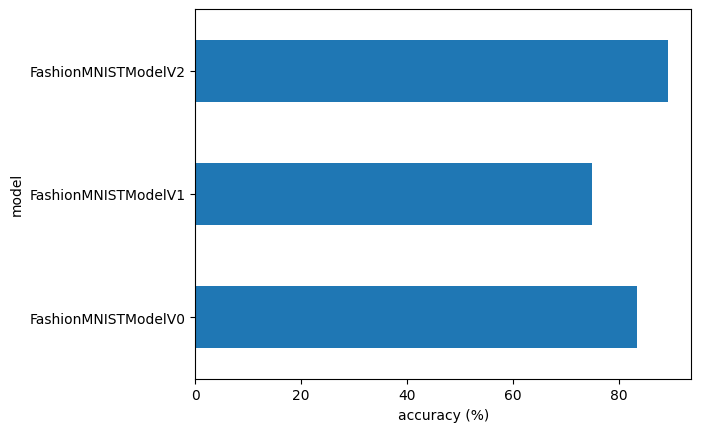

In [171]:

# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 9. Make and evaluate random predictions with best model

In [172]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [173]:
# select 9 random samples to predict

import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Bag')

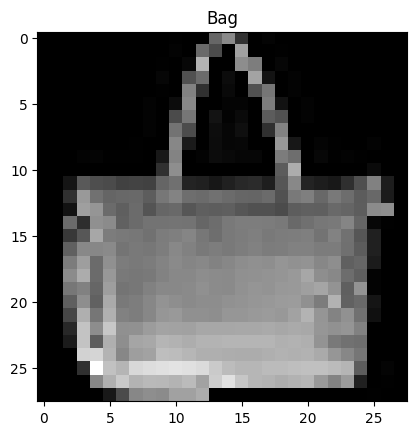

In [175]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [176]:

# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first prediction probabilities
pred_probs[:1]

tensor([[6.3039e-09, 4.3402e-10, 1.4162e-08, 4.7247e-08, 2.1456e-08, 2.0093e-09,
         2.9965e-08, 1.9811e-07, 1.0000e+00, 4.3684e-08]])

In [178]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 5, 8, 1, 8, 2, 8, 0, 5])

In [179]:
# note that the predictions match up exactly with the ground truth
test_labels

[8, 5, 8, 1, 8, 2, 8, 0, 5]

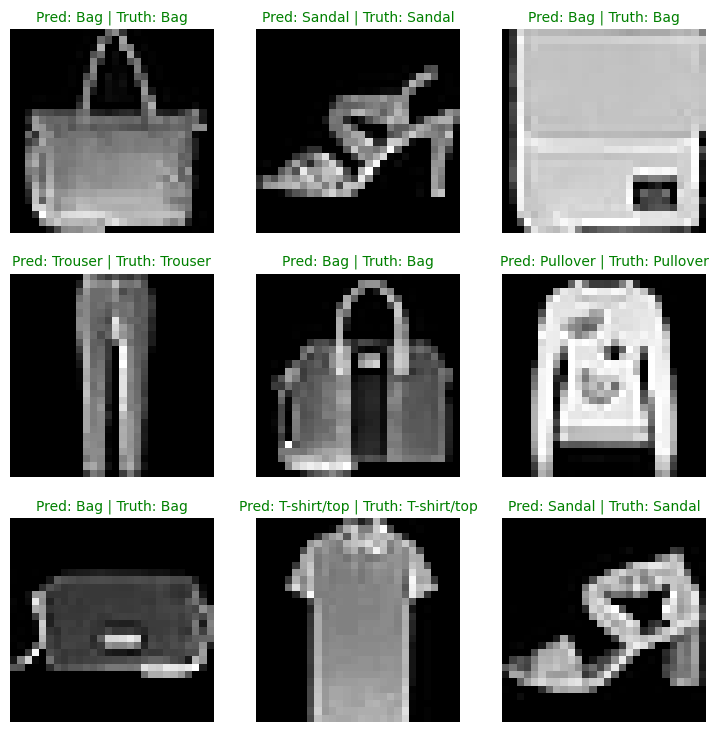

In [183]:
# Plot predictions, visualized the above results
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False);

## 10. Making a confusion matrix for further prediction evaluation